In [2]:
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

print("All imports are working!")


All imports are working!


In [3]:
# --- Constants ---
IMG_SIZE = (224, 224)  # ResNet50 recommended input size
BATCH_SIZE = 32
EPOCHS_STAGE_1 = 10    # Initial training
EPOCHS_STAGE_2 = 10    # Fine-tuning
LEARNING_RATE_STAGE_1 = 1e-4
LEARNING_RATE_STAGE_2 = 1e-5

In [4]:
# Define paths
train_dir = Path('../data/seg_train/seg_train')
test_dir = Path('../data/seg_test/seg_test')
model_save_path = Path('../models/transfer_learning_resnet50.h5')

In [5]:
# --- Data Generators ---
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [6]:
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 11230 images belonging to 6 classes.


In [7]:
validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2804 images belonging to 6 classes.


In [8]:
# --- Model Architecture ---
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers initially

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Single Dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
# --- Compile Stage 1 ---
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE_STAGE_1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Callbacks ---
checkpoint = ModelCheckpoint(filepath=str(model_save_path),
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                               factor=0.2,
                               patience=2,
                               min_lr=1e-6,
                               verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy',
                            patience=5,
                            restore_best_weights=True)

# --- Stage 1 Training (Frozen Base) ---
print("Stage 1: Training top layers only...")
history_stage1 = model.fit(train_generator,
                           epochs=EPOCHS_STAGE_1,
                           validation_data=validation_generator,
                           callbacks=[checkpoint, reduce_lr, early_stop])

print(f"Training complete. Best model saved to {model_save_path}")

Stage 1: Training top layers only...


c:\Users\hp\assignment\myvenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7041 - loss: 0.8169
Epoch 1: val_accuracy improved from None to 0.89158, saving model to ..\models\transfer_learning_resnet50.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - accuracy: 0.8005 - loss: 0.5590 - val_accuracy: 0.8916 - val_loss: 0.2825 - learning_rate: 1.0000e-04
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8652 - loss: 0.3732
Epoch 2: val_accuracy improved from 0.89158 to 0.91084, saving model to ..\models\transfer_learning_resnet50.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 905s 3s/step - accuracy: 0.8673 - loss: 0.3699 - val_accuracy: 0.9108 - val_loss: 0.2449 - learning_rate: 1.0000e-04
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8814 - loss: 0.3147
Epoch 3: val_accuracy improved from 0.91084 to 0.91940, saving model to ..\models\transfer_learning_resnet50.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 902s 3s/step - accuracy: 0.8775 - loss: 0.3280 - val_accuracy: 0.9194 - val_loss: 0.2317 - learning_rate: 1.0000e-04
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8850 - loss: 0.3167
Epoch 4: val_accuracy did not improve from 0.91940
351/351 ━━━━━━━━━━━━━━━━━━━━ 952s 3s/step - accuracy: 0.8823 - loss: 0.3185 - val_accuracy: 0.9183 - val_loss: 0.2220 - learning_rate: 1.0000e-04
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8874 - loss: 0.2896
Epoch 5: val_accuracy did not improve from 0.91940

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
351/351 ━━━━━━━━━━━━━━━━━━━━ 791s 2s/step - accuracy: 0.8891 - loss: 0.2937 - val_accuracy: 0.9158 - val_loss: 0.2236 - learning_rate: 1.0000e-04
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8966 - loss: 0.2768
Epoch 6: val_accuracy did not improve from 0.91940
351/351 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.8984 - loss: 0.2738 

351/351 ━━━━━━━━━━━━━━━━━━━━ 790s 2s/step - accuracy: 0.9013 - loss: 0.2674 - val_accuracy: 0.9208 - val_loss: 0.2188 - learning_rate: 2.0000e-05
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9056 - loss: 0.2518
Epoch 8: val_accuracy improved from 0.92083 to 0.92190, saving model to ..\models\transfer_learning_resnet50.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 785s 2s/step - accuracy: 0.9023 - loss: 0.2605 - val_accuracy: 0.9219 - val_loss: 0.2151 - learning_rate: 2.0000e-05
Epoch 9/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9023 - loss: 0.2612
Epoch 9: val_accuracy improved from 0.92190 to 0.92368, saving model to ..\models\transfer_learning_resnet50.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 782s 2s/step - accuracy: 0.9036 - loss: 0.2620 - val_accuracy: 0.9237 - val_loss: 0.2123 - learning_rate: 2.0000e-05
Epoch 10/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9074 - loss: 0.2534
Epoch 10: val_accuracy did not improve from 0.92368
351/351 ━━━━━━━━━━━━━━━━━━━━ 903s 3s/step - accuracy: 0.9077 - loss: 0.2525 - val_accuracy: 0.9230 - val_loss: 0.2144 - learning_rate: 2.0000e-05
Training complete. Best model saved to ..\models\transfer_learning_resnet50.h5


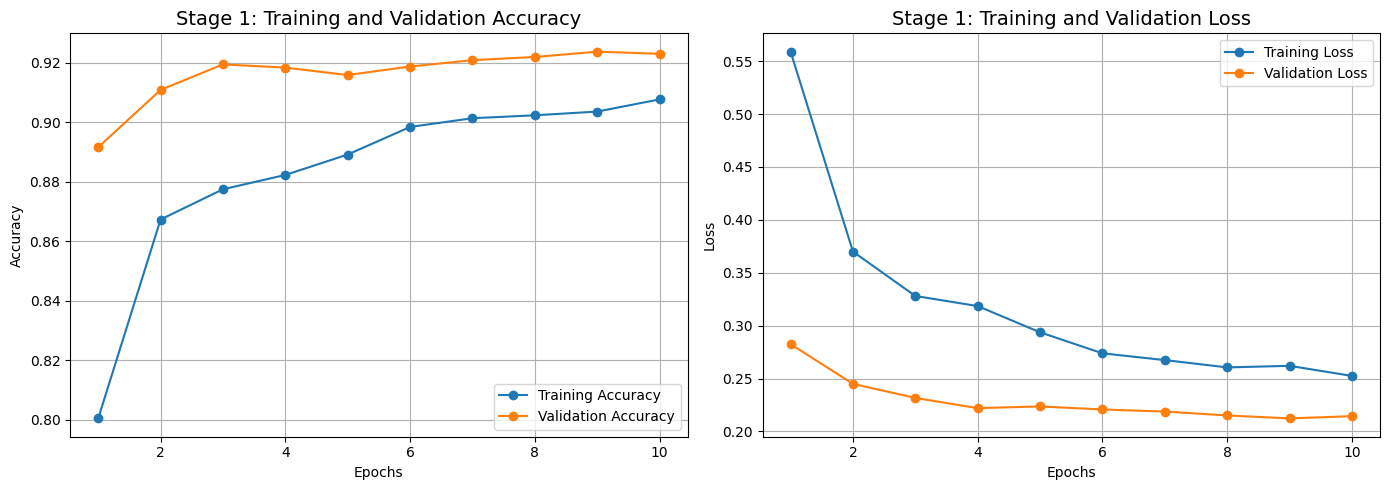

In [11]:
# --- CELL: Plot Stage 1 Training History ---
import matplotlib.pyplot as plt

# Extract metrics from history_stage1
acc = history_stage1.history.get('accuracy', [])
val_acc = history_stage1.history.get('val_accuracy', [])
loss = history_stage1.history.get('loss', [])
val_loss = history_stage1.history.get('val_loss', [])

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# --- Accuracy plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Stage 1: Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# --- Loss plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Stage 1: Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
# ------------------------------
# Custom CNN Training Script
# ------------------------------

from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [13]:
# --- Constants ---
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 20  # You can adjust
NUM_CLASSES = 6

train_dir = Path('../data/seg_train/seg_train')
validation_dir = Path('../data/seg_train/seg_train')  # using subset split for validation
model_save_path = Path('../models/custom_cnn.keras')  # modern Keras format

In [14]:
# --- Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [15]:
# --- Build Custom CNN ---
custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

custom_model.summary()


c:\Users\hp\assignment\myvenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,331,398 (81.37 MB)

 Trainable params: 21,330,950 (81.37 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# --- Compile the Model ---
custom_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
checkpoint = ModelCheckpoint(
    filepath=str(model_save_path),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- Train the Model ---
history = custom_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

print(f"Training complete. Best model saved to {model_save_path}")

c:\Users\hp\assignment\myvenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4779 - loss: 2.0075
Epoch 1: val_accuracy improved from None to 0.64265, saving model to ..\models\custom_cnn.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 500s 1s/step - accuracy: 0.5283 - loss: 1.4464 - val_accuracy: 0.6427 - val_loss: 0.9697 - learning_rate: 1.0000e-04
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5971 - loss: 1.0684
Epoch 2: val_accuracy improved from 0.64265 to 0.69971, saving model to ..\models\custom_cnn.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 544s 2s/step - accuracy: 0.6050 - loss: 1.0499 - val_accuracy: 0.6997 - val_loss: 0.8265 - learning_rate: 1.0000e-04
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6062 - loss: 1.0182
Epoch 3: val_accuracy improved from 0.69971 to 0.73217, saving model to ..\models\custom_cnn.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.6248 - loss: 0.9929 - val_accuracy: 0.7322 - val_loss: 0.7405 - learning_rate: 1.0000e-04
Epoch 4/20
35

In [ ]:
# --- CELL: Plot Training History ---
import matplotlib.pyplot as plt

# Extract metrics from history
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# --- Accuracy plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# --- Loss plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()
